Running on PyMC3 v3.11.5


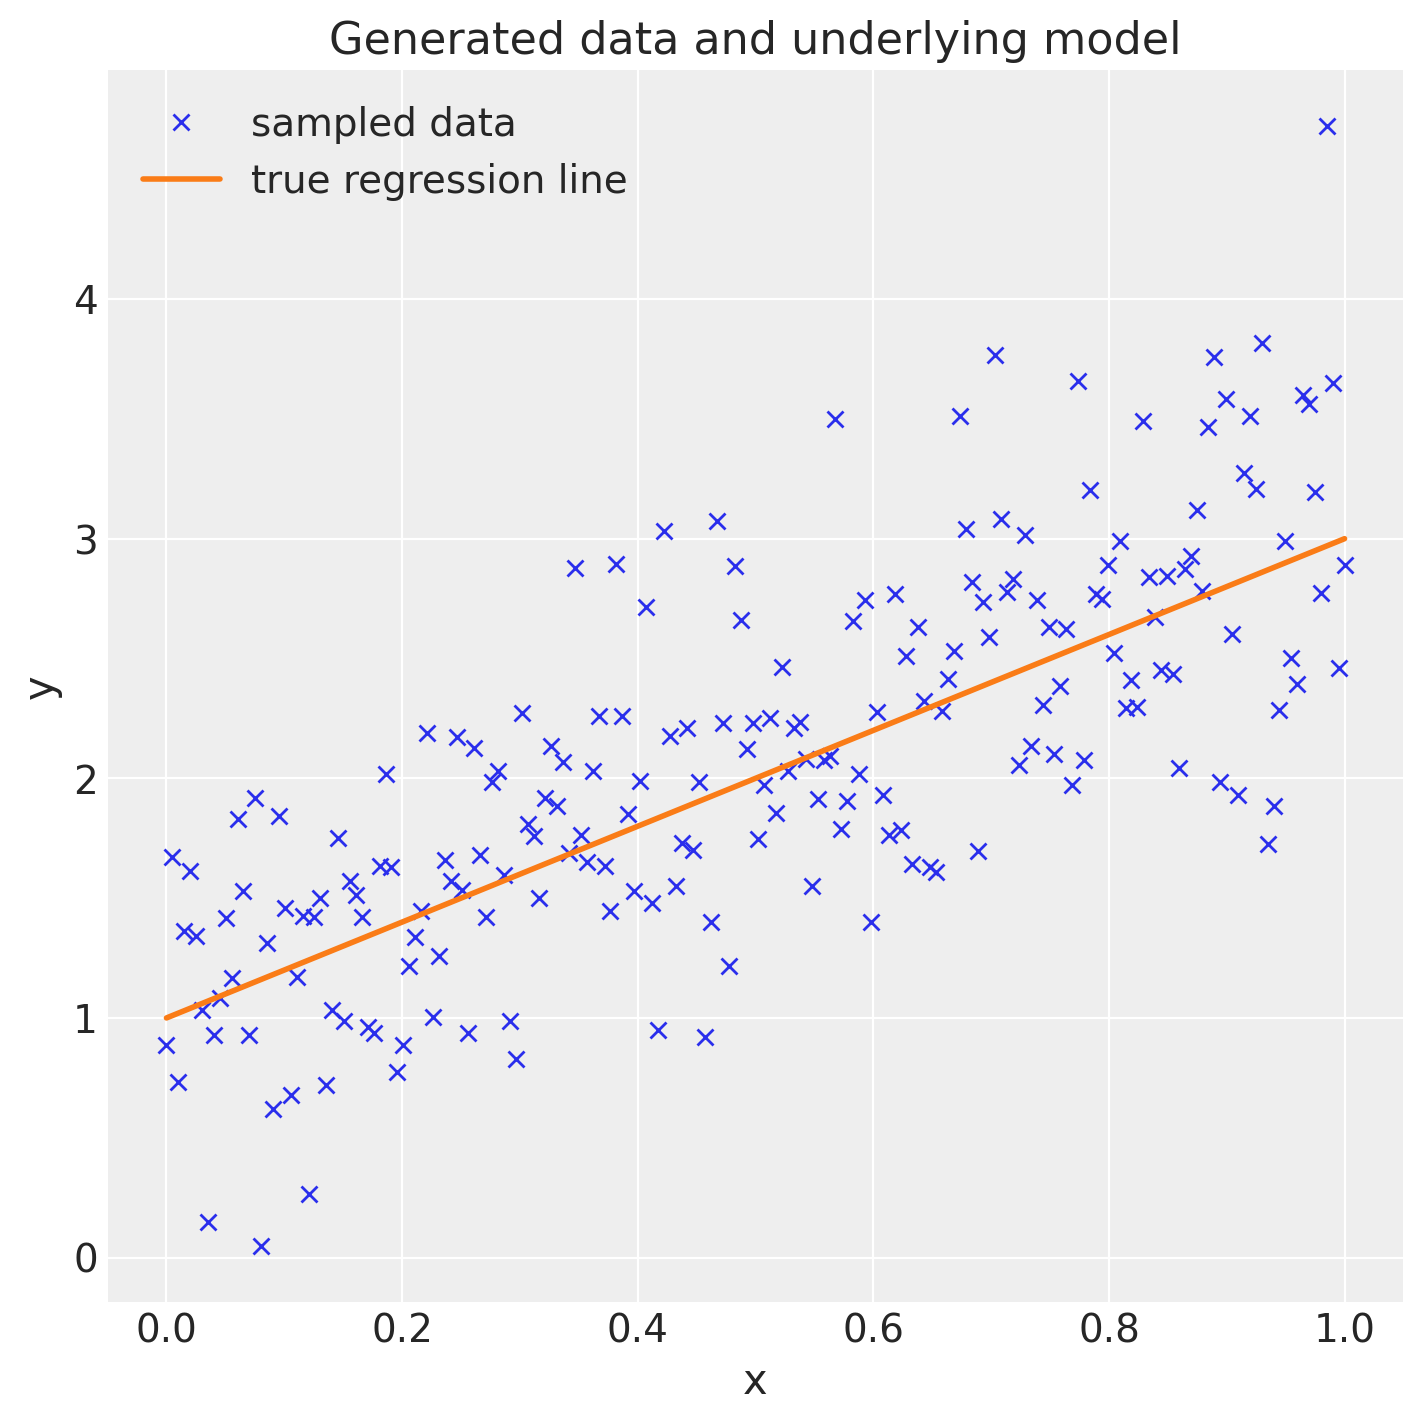

In [3]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

print(f"Running on PyMC3 v{pm.__version__}")
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [4]:
with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("Intercept", 0, sigma=20)
    x_coeff = Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]


/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8833621905743316, but should be close to 0.8. Try to increase the numb

In [5]:
model = bmb.Model("y ~ x", data)
trace = model.fit(draws=3000)

AssertionError: 

In [6]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [7]:
model.basic_RVs

[mu ~ Normal, obs ~ Normal]

In [8]:
model.free_RVs

[mu ~ Normal]

In [9]:
model.observed_RVs

[obs ~ Normal]

In [10]:
print(type(mu),type(obs))

<class 'pymc3.model.FreeRV'> <class 'pymc3.model.ObservedRV'>


In [11]:
model.logp({"mu": 0})

array(-136.62966222)

In [12]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

23.7 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.41 µs ± 6.73 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [14]:
from pymc3 import Model, Normal, invlogit, Binomial, sample, forestplot
import numpy as np
n = np.ones(4)*5
y = np.array([0, 1, 3, 5])
dose = np.array([-.86,-.3,-.05,.73])

with Model() as bioassay_model:

    # Prior distributions for latent variables
    alpha = Normal('alpha', 0, sd=100)
    beta = Normal('beta', 0, sd=100)

    # Linear combinations of parameters
    theta = invlogit(alpha + beta*dose)

    # Model likelihood
    deaths = Binomial('deaths', n=n, p=theta, observed=y)


In [15]:
with bioassay_model:

    # Draw samples
    trace = sample(1000, njobs=2)
    # Plot two parameters
    forestplot(trace, varnames=['alpha', 'beta'])

/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


TypeError: function() got an unexpected keyword argument 'njobs'

In [ ]:
# run the examples under 3.8
#https://github.com/springcoil/probabilisticprogrammingprimer/tree/master/notebooks/pymc38


In [16]:
# Data
from pymc3 import Model, Normal, invlogit, Binomial, sample, forestplot
import numpy as np
n = np.ones(4)*5
y = np.array([0, 1, 3, 5])
dose = np.array([-.86,-.3,-.05,.73])

with Model() as bioassay_model:

    # Prior distributions for latent variables
    alpha = Normal('alpha', 0, sd=100)
    beta = Normal('beta', 0, sd=100)

    # Linear combinations of parameters
    theta = invlogit(alpha + beta*dose)

    # Model likelihood
    deaths = Binomial('deaths', n=n, p=theta, observed=y)


/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/4d/q427n_f576n48f63r9jty87r0000gn/T/ipykernel_10442/1421609221.py:6: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  forestplot(trace)


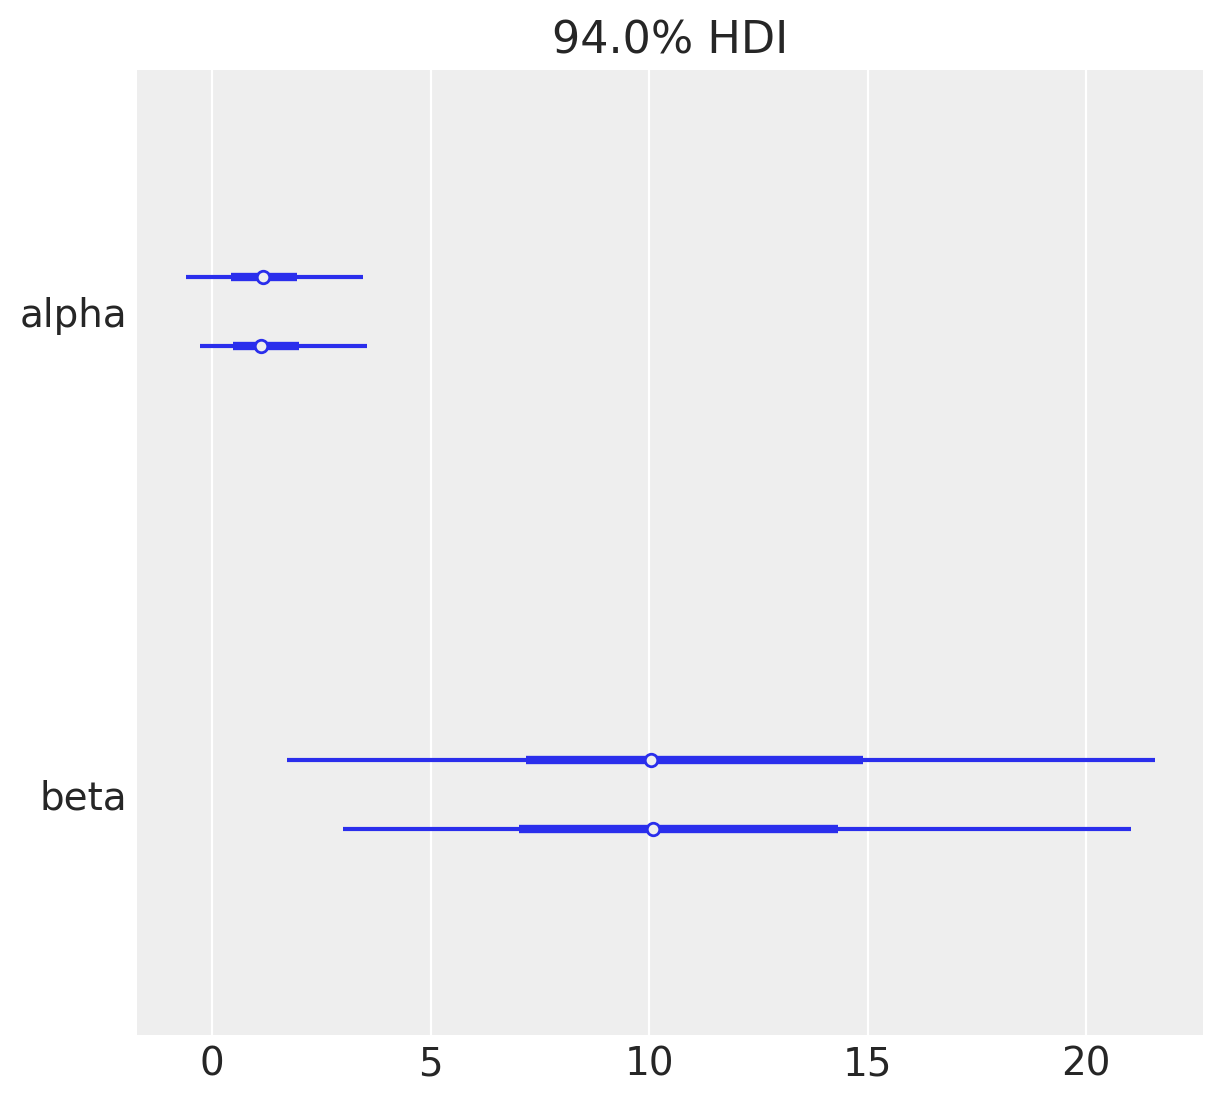

In [20]:
with bioassay_model:

    # Draw samples
    trace = sample(1000, cores=2)
    # Plot two parameters
    #remove varnames parameter and args
    forestplot(trace)

/var/folders/4d/q427n_f576n48f63r9jty87r0000gn/T/ipykernel_10442/341022507.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace[500:]);
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


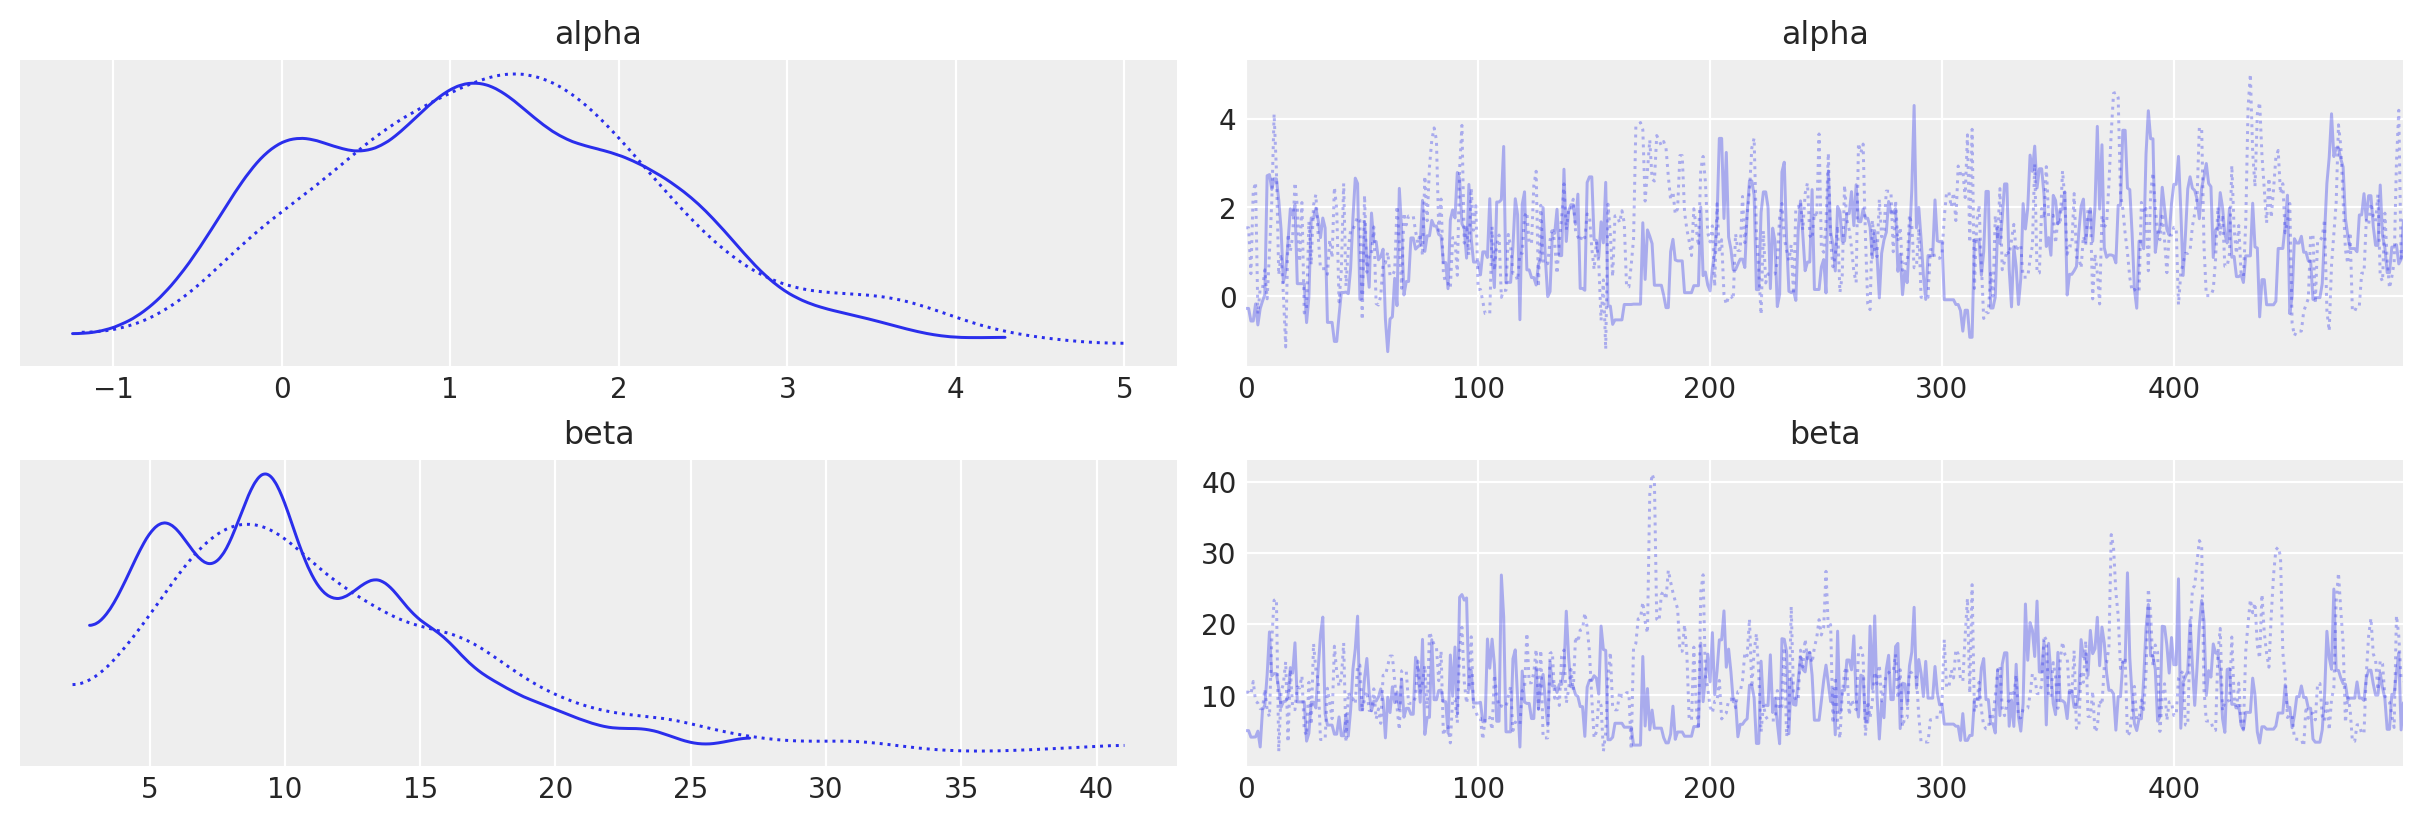

In [21]:
from pymc3 import traceplot
#remove varnames
traceplot(trace[500:]);

num years: 111


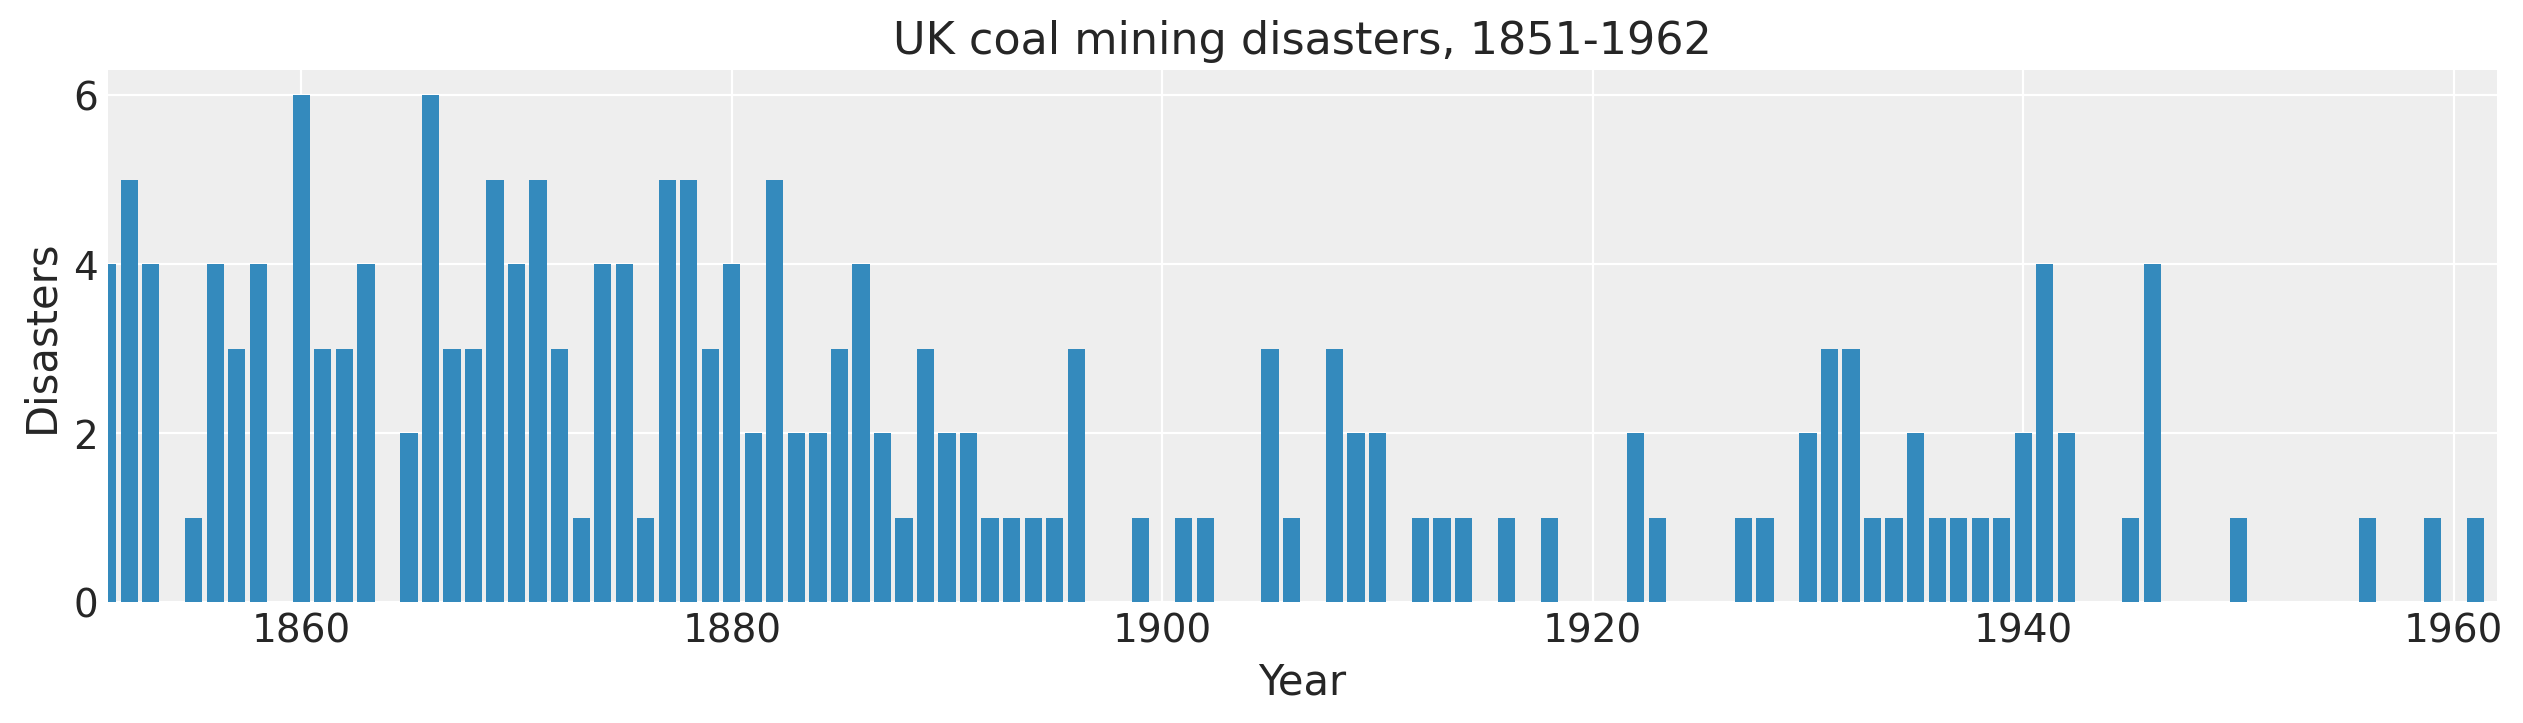

In [23]:
#coal mining disasters the number of disasters should have been reduced by regulation
#hierarchial model? 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_years = len(disasters_data)
print("num years:",n_years)
plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_data, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

/var/folders/4d/q427n_f576n48f63r9jty87r0000gn/T/ipykernel_10442/1256077240.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


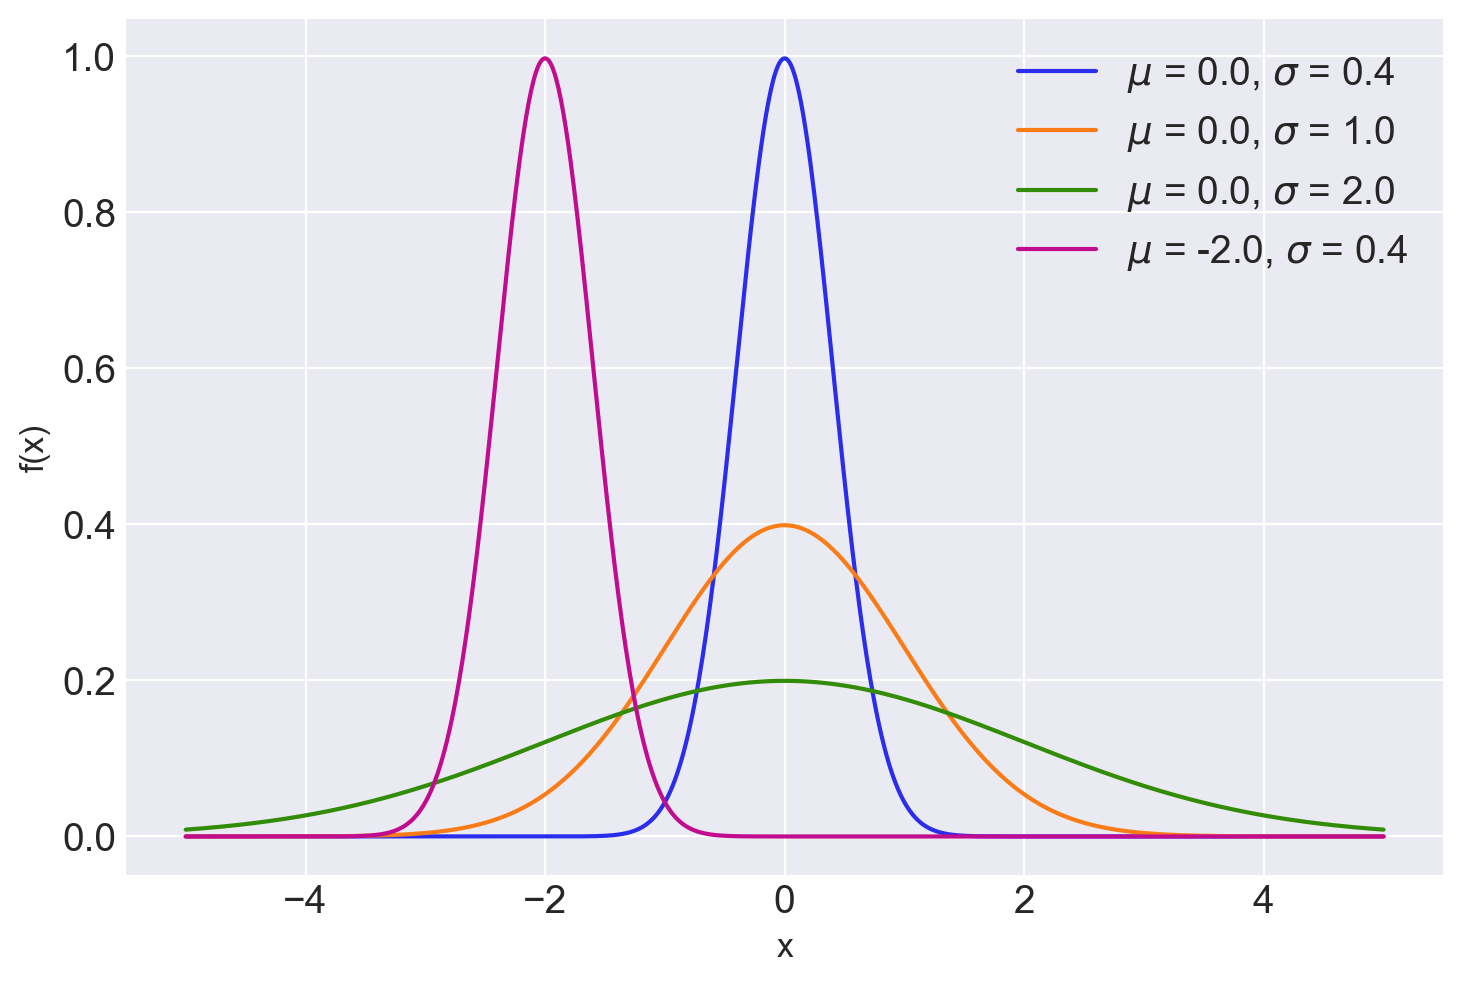

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(-5, 5, 1000)
mus = [0., 0., 0., -2.]
sigmas = [0.4, 1., 2., 0.4]
for mu, sigma in zip(mus, sigmas):
    pdf = st.norm.pdf(x, mu, sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [34]:
def plot_cont(self, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = self.random(size=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(self.logp(x)).eval())
    return ax

# Assign this distribution to the abstract class Continuous
pm.Continuous.plot = plot_cont

<AxesSubplot: >

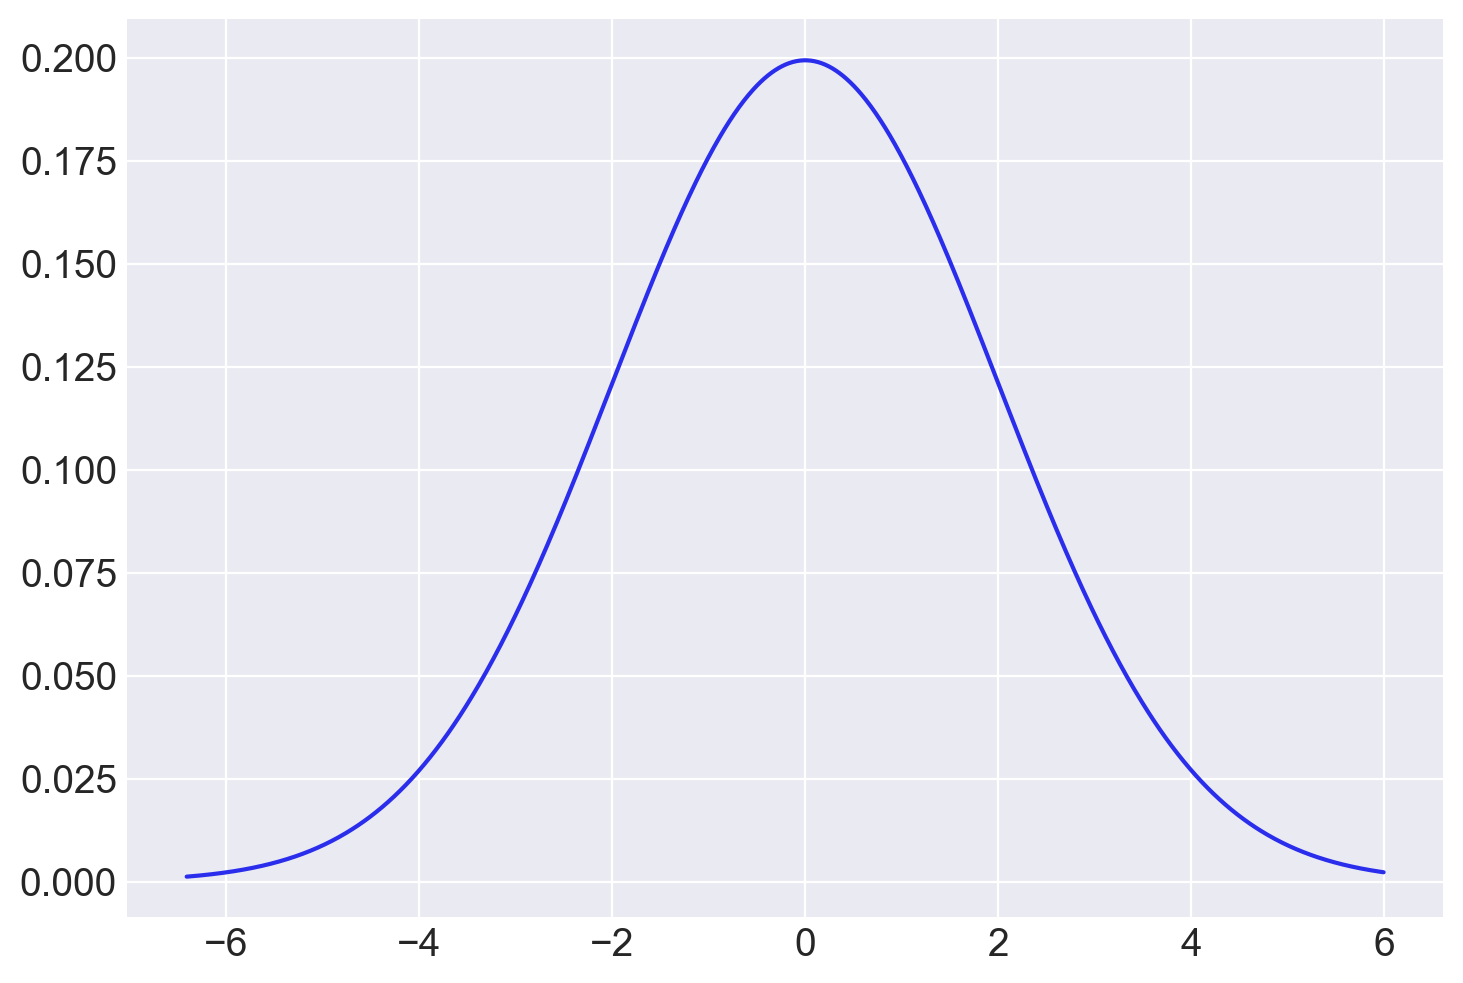

In [40]:
pm.Normal.dist(mu=0, sd=2).plot()

In [39]:
def plot_disc(self, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = self.random(size=1000)
    x = np.arange(np.min(samples), np.max(samples)+1)
    plt.plot(x, np.exp(self.logp(x)).eval(), "-o")
    return ax

# add plot method to abstract class Continuous
pm.Discrete.plot = plot_disc

<AxesSubplot: >

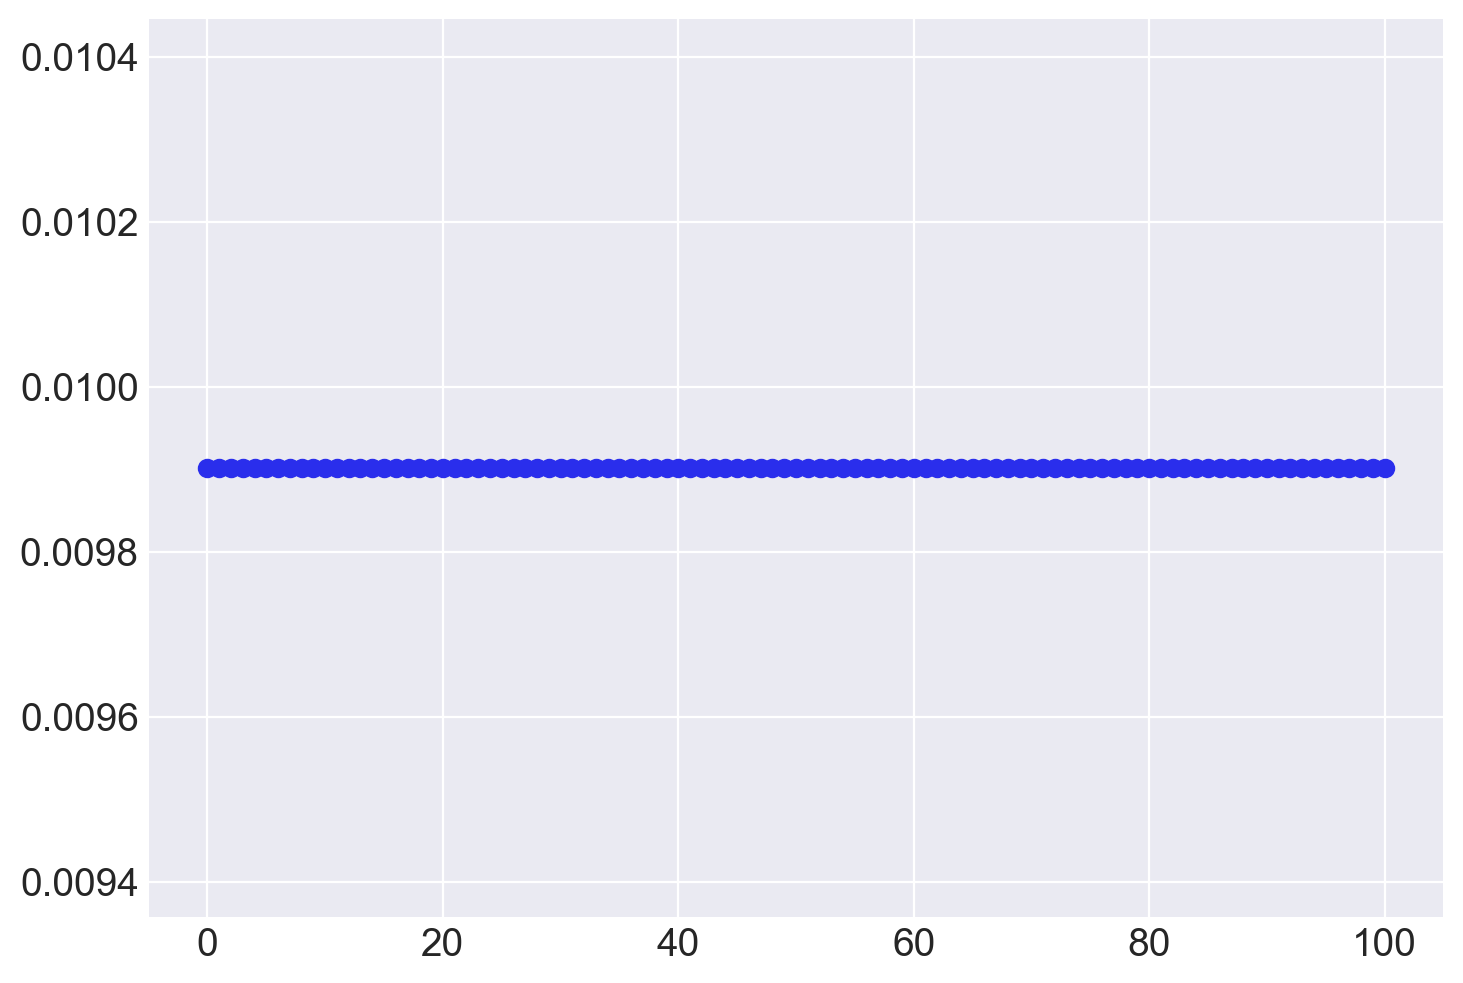

In [41]:
x = DiscreteUniform.dist(lower=0, upper=100)
x.plot()



/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [switchpoint]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/4d/q427n_f576n48f63r9jty87r0000gn/T/ipykernel_10442/67552317.py:10: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/dougchang/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'switchpoint'}>,
        <AxesSubplot: title={'center': 'switchpoint'}>]], dtype=object)

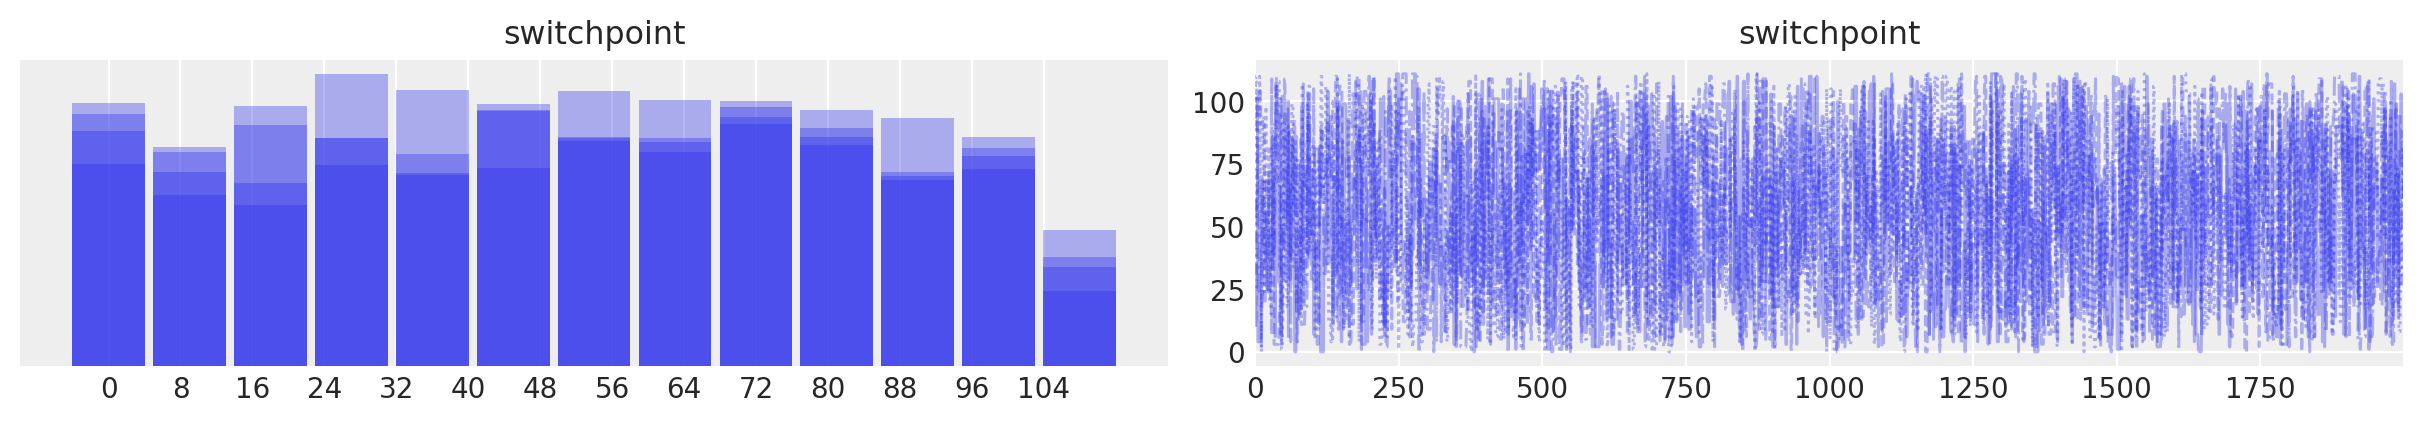

In [29]:
from pymc3 import DiscreteUniform

with Model() as disaster_model:
    switchpoint = DiscreteUniform('switchpoint', lower=0, upper=n_years)
    #trace = sample(1000, cores=2)

#traceplot(trace[500:]);
with disaster_model:
    trace = sample(2000)
traceplot(trace)